In [59]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno

from sklearn.feature_selection import mutual_info_classif

pd.plotting.register_matplotlib_converters()
%matplotlib inline

import duckdb
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import precision_score, roc_auc_score, recall_score, accuracy_score

from sklearn.model_selection import train_test_split
from lightgbm import LGBMClassifier

%load_ext autoreload
%autoreload 2
from help_tool import help_tool, help_visuals, help_stats

pd.set_option('future.no_silent_downcasting', True)

# Setting graph parameters
sns.set_theme(style='whitegrid')
sns.set_palette('husl')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [60]:
pos_cash = help_tool.csv_download(r'Archive\home-credit-default-risk\POS_CASH_balance.csv')
help_tool.first_look(pos_cash)

Dataset has 10001358 observations and 8 features
Columns with all empty values []
Dataset has 0 duplicates


,dtypes,"Null values, Count","Null values, %"
SK_ID_PREV,int64,0,0.0
SK_ID_CURR,int64,0,0.0
MONTHS_BALANCE,int64,0,0.0
CNT_INSTALMENT,float64,26071,0.3
CNT_INSTALMENT_FUTURE,float64,26087,0.3
NAME_CONTRACT_STATUS,object,0,0.0
SK_DPD,int64,0,0.0
SK_DPD_DEF,int64,0,0.0


## Null values

In [ ]:
pos_cash[pos_cash['CNT_INSTALMENT'].isna() & pos_cash['CNT_INSTALMENT_FUTURE'].notna()]['NAME_CONTRACT_STATUS'].value_counts()

Null values will be dropped

In [ ]:
pos_cash = pos_cash[pos_cash['CNT_INSTALMENT'].notna() & pos_cash['CNT_INSTALMENT_FUTURE'].notna()]

## EDA

MONTHS_BALANCE


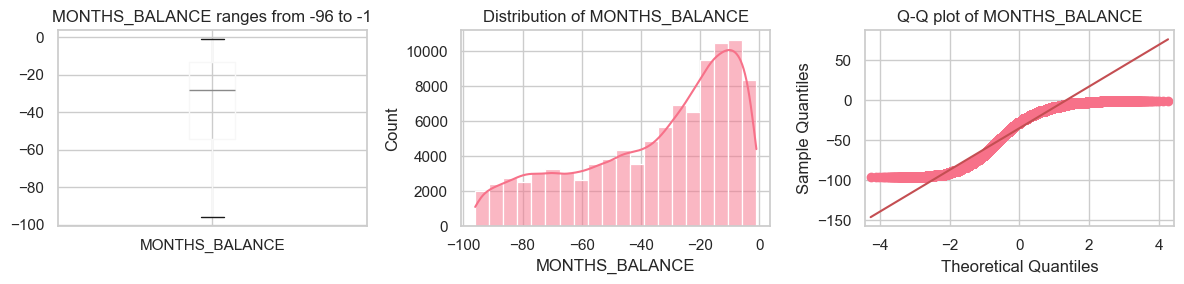

CNT_INSTALMENT


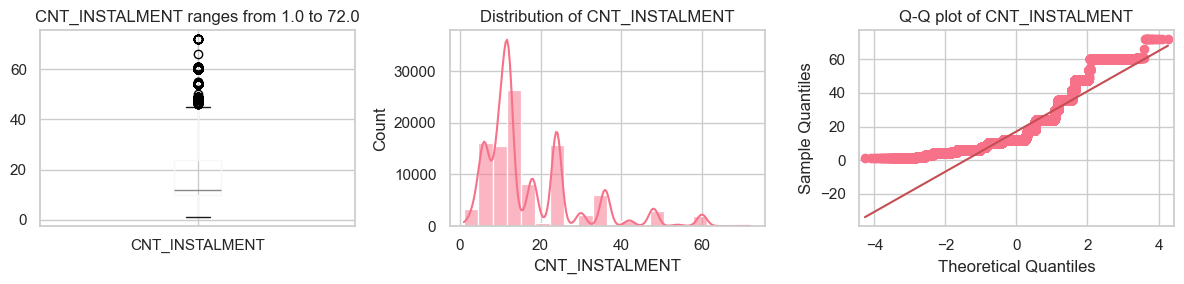

CNT_INSTALMENT_FUTURE


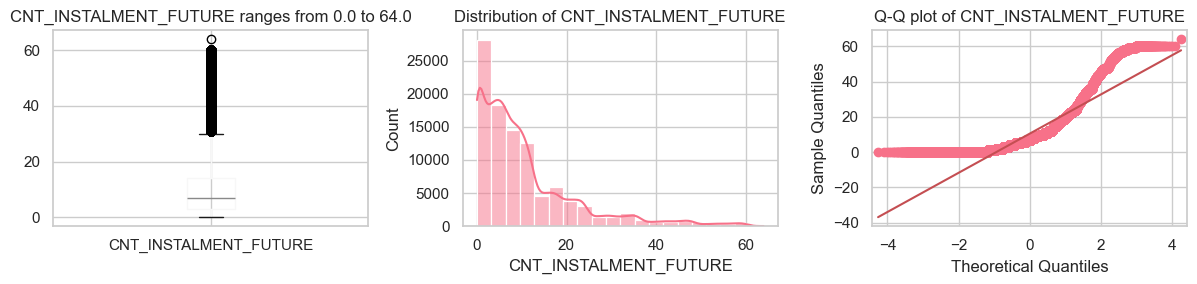

SK_DPD


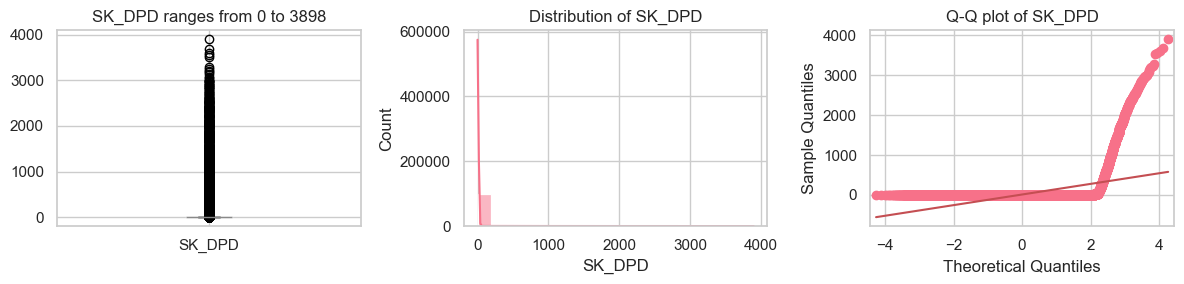

SK_DPD_DEF


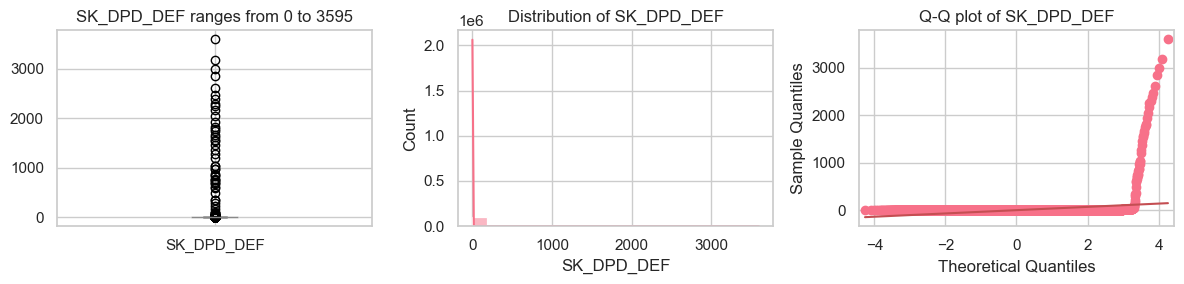

In [91]:
help_visuals.distribution_check(pos_cash.drop(columns=['SK_ID_PREV', 'SK_ID_CURR']).sample(100000, random_state=42))

## Canceled Status

In [61]:
pos_cash['NAME_CONTRACT_STATUS'].value_counts()

NAME_CONTRACT_STATUS
Active                   9151119
Completed                 744883
Signed                     87260
Demand                      7065
Returned to the store       5461
Approved                    4917
Amortized debt               636
Canceled                      15
XNA                            2
Name: count, dtype: int64

In [66]:
from sklearn.preprocessing import MinMaxScaler

def normalize_group(group):
    scaler = MinMaxScaler()
    group['MONTHS_BALANCE'] = scaler.fit_transform(group[['MONTHS_BALANCE']])
    return group

In [71]:
canceled_list = pos_cash[pos_cash['NAME_CONTRACT_STATUS'] == 'Canceled']['SK_ID_PREV'].to_list()
pos_cash_canceled = pos_cash[pos_cash['SK_ID_PREV'].isin(canceled_list)]
pos_cash_canceled = pos_cash_canceled.groupby(['SK_ID_PREV', 'SK_ID_CURR']).apply(normalize_group, include_groups=True).reset_index(drop=True)

C:\Users\Gintare\AppData\Local\Temp\ipykernel_5340\867212471.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  pos_cash_canceled = pos_cash_canceled.groupby(['SK_ID_PREV', 'SK_ID_CURR']).apply(normalize_group, include_groups=True).reset_index(drop=True)


In [73]:
status_order = ['Canceled', 'Signed', 'Returned to the store', 'Approved', 'Active', 'Completed']
pos_cash_canceled['NAME_CONTRACT_STATUS'] = pd.Categorical(
    pos_cash_canceled['NAME_CONTRACT_STATUS'],
    categories=status_order,
    ordered=True
)

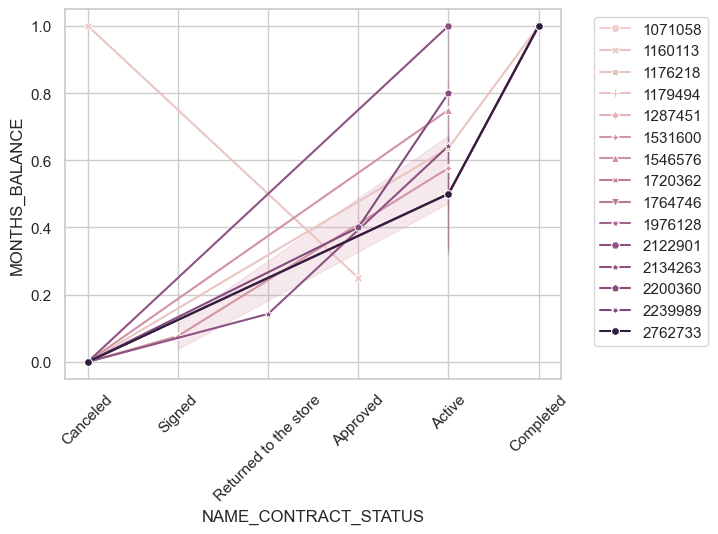

In [83]:
sns.lineplot(data=pos_cash_canceled, y='MONTHS_BALANCE', x='NAME_CONTRACT_STATUS', hue='SK_ID_PREV', style='SK_ID_PREV', legend='full', markers=True, dashes=False)

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title('Canceled Status Route')
plt.xticks(rotation=45)
plt.show()

All Canceled trades end up Active or Completed

## Feature engineering

In [119]:
pos_cash_expanded = help_tool.dummy_columns(pos_cash, ['NAME_CONTRACT_STATUS'])

pos_cash_expanded = duckdb.query("""
             SELECT 
                SK_ID_PREV, SK_ID_CURR, 
                SUM(SK_DPD) AS SUM_SK_DPD, 
                SUM(SK_DPD_DEF) AS SUM_DPD_DEF, 
                SUM(NAME_CONTRACT_STATUS_Active) AS NAME_CONTRACT_STATUS_Active, 
                SUM("NAME_CONTRACT_STATUS_Amortized debt") AS NAME_CONTRACT_STATUS_Amortized_debt, 
                SUM(NAME_CONTRACT_STATUS_Approved) AS NAME_CONTRACT_STATUS_Approved, 
                SUM(NAME_CONTRACT_STATUS_Canceled) AS NAME_CONTRACT_STATUS_Canceled, 
                SUM(NAME_CONTRACT_STATUS_Completed) AS NAME_CONTRACT_STATUS_Completed,	
                SUM(NAME_CONTRACT_STATUS_Demand) AS NAME_CONTRACT_STATUS_Demand, 
                SUM("NAME_CONTRACT_STATUS_Returned to the store") AS AME_CONTRACT_STATUS_Returned_to_the_store, 
                SUM(NAME_CONTRACT_STATUS_Signed) AS NAME_CONTRACT_STATUS_Signed
             FROM pos_cash_expanded
             GROUP BY SK_ID_PREV, SK_ID_CURR
""").to_df()

pos_cash_expanded.head()

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

,SK_ID_PREV,SK_ID_CURR,SUM_SK_DPD,SUM_DPD_DEF,NAME_CONTRACT_STATUS_Active,NAME_CONTRACT_STATUS_Amortized_debt,NAME_CONTRACT_STATUS_Approved,NAME_CONTRACT_STATUS_Canceled,NAME_CONTRACT_STATUS_Completed,NAME_CONTRACT_STATUS_Demand,AME_CONTRACT_STATUS_Returned_to_the_store,NAME_CONTRACT_STATUS_Signed
0,1185412,257737,0.0,0.0,12.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,2119427,331456,0.0,0.0,5.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,1846703,190073,0.0,0.0,6.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,1944705,346044,0.0,0.0,10.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,1725960,264710,0.0,0.0,4.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
